In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

import advopt
from advopt import plot_convergence, distance_to, tasks
from advopt import OptimizationResults

import os
ROOT = os.path.dirname(os.path.dirname(advopt.__file__))
DATA_ROOT = os.path.join(ROOT, 'results')
FIG_ROOT = os.path.join(ROOT, 'figures')

os.makedirs(FIG_ROOT, exist_ok=True)

/mnt/mborisyak/.pyenv/versions/3.7.6/envs/py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/mnt/mborisyak/.pyenv/versions/3.7.6/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
### just for loading solution
task = tasks.PythiaTracker()

budget = 32 * 1024

In [3]:
results = dict()

avo_results = [
    item
    for item in os.listdir(os.path.join(DATA_ROOT, 'AVO'))
    if item.startswith('AVO') and item.endswith('pickled')
]

for path in avo_results:
    path = os.path.join(DATA_ROOT, 'AVO', path)
    
    with open(path, 'rb') as f:
        rs = pickle.load(f)
        for k, v in rs.items():
            if k not in results:
                results[k] = list()
            
            results[k].append(v)

In [4]:
### reorder
results = {
    'control' : results['control'],
    'dropout' : results['dropout'],
    'l2' : results['l2'],
}

properties = {
    'control': dict(color='black', label='JSD'),
    'dropout': dict(color=plt.cm.tab10(0), label='AD, dropout'),
    'l2': dict(color=plt.cm.tab10(1), label='AD, l2'),
}

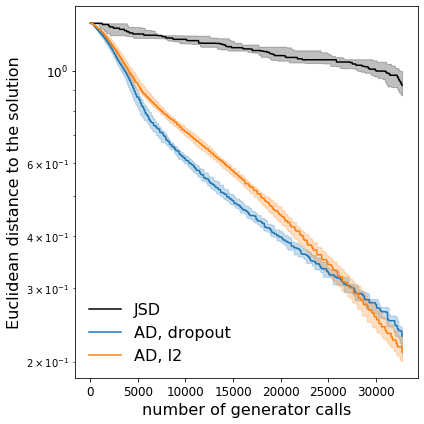

In [5]:
plt.figure(figsize=(6, 6))
plot_convergence(
    results, distance_to(task.solution()),
    qs=(0.25,), budget=budget,
    properties=properties,
    individual=False, mode=None,
)

plt.xlabel('number of generator calls', fontsize=16)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Euclidean distance to the solution', fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='lower left', fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-5a.pdf'))

In [6]:
costs = {
    k : np.log2(
        np.concatenate([
            res.costs
            for res in results[k]
        ], axis=0)
    )
    for k in results
}

all_costs = np.concatenate([costs[k] for k in costs], axis=0)

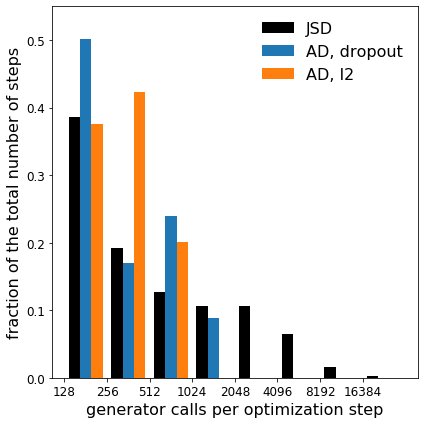

In [7]:
plt.figure(figsize=(6, 6))
a, b = int(np.floor(np.min(all_costs))), int(np.ceil(np.max(all_costs)))

plt.hist(
    list(costs.values()),
    label=[properties[k]['label'] for k in costs],
    color=[properties[k]['color'] for k in costs],
    histtype='bar', bins=b - a, range=(a, b), log=False,
    lw=2, density=True
)

plt.xticks(ticks=range(a, b), labels=['%d' % (2 ** i) for i in range(a, b)], fontsize=12)
plt.xlabel('generator calls per optimization step', fontsize=16)

plt.yticks(fontsize=12)
plt.ylim([0, 0.55])
plt.ylabel('fraction of the total number of steps', fontsize=16)

plt.legend(loc='upper right', fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-5b.pdf'))

In [8]:
step_results = {
    k : [
        OptimizationResults(points=r.points, values=r.values, costs=np.ones_like(r.costs), seed=r.seed)
        for r in results[k]
    ]
    for k in results
}

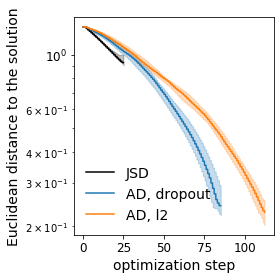

In [9]:
plt.figure(figsize=(4, 4))
plot_convergence(
    step_results, distance_to(task.solution()), qs=(0.25, ),
    properties=properties,
    individual=False, extrapolate=False, mode=None
)

plt.xlabel('optimization step', fontsize=14)
plt.xticks(fontsize=12)

plt.ylabel('Euclidean distance to the solution', fontsize=14)
plt.yticks(fontsize=12)
plt.yscale('log')

plt.legend(loc='lower left', fontsize=14, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, 'Figure-6c.pdf'))